In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, MinMaxScaler
from scipy.sparse import hstack, csr_matrix
import numpy as np

# Load your data
df = pd.read_excel('/content/drive/My Drive/Colab/AS4/STEP4-Champion_Clustering&Classification_Save&Evaluation/Raw_with_predicted_classification_label.xlsx')

# Fill missing values
df['Authors'] = df['Author'].fillna('')
df['Document_Type'] = df['Document Type'].fillna('Unknown')
df['Publication_Year'] = df['Publication Year'].fillna(df['Publication Year'].median())

# ---------- AUTHORS ----------
# Split authors on "; " and keep top 100 authors to limit sparsity
all_authors = df['Authors'].str.split('; ')
flat_authors = [a for sublist in all_authors for a in sublist if a.strip()]
top_authors = pd.Series(flat_authors).value_counts().nlargest(100).index.tolist()

# Filter and rejoin only top authors
df['Filtered_Authors'] = all_authors.apply(lambda lst: [a for a in lst if a in top_authors])

# Binarize author features
mlb = MultiLabelBinarizer()
author_matrix = mlb.fit_transform(df['Filtered_Authors'])

# ---------- DOCUMENT TYPE ----------
ohe_doc_type = OneHotEncoder(sparse_output=True)
doc_type_matrix = ohe_doc_type.fit_transform(df[['Document_Type']])


# ---------- PUBLICATION YEAR ----------
scaler_year = MinMaxScaler()
year_matrix = scaler_year.fit_transform(df[['Publication_Year']])

# Convert to sparse matrix
year_matrix_sparse = csr_matrix(year_matrix)

# ---------- COMBINE ----------
metadata_matrix = hstack([author_matrix, doc_type_matrix, year_matrix_sparse])


In [ ]:
from scipy.sparse import save_npz

save_npz('/content/drive/My Drive/Colab/AS4/STEP2-feature_Engineering/metadata_matrix.npz', metadata_matrix)


In [23]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import load_npz
import numpy as np

# Load the same dataframe (with citation info)
df = pd.read_excel('/content/drive/My Drive/Colab/AS4/STEP4-Champion_Clustering&Classification_Save&Evaluation/Raw_with_predicted_classification_label.xlsx')

# Load feature matrices
tfidf_matrix = load_npz('/content/drive/My Drive/Colab/AS4/STEP2-feature_Engineering/tfidf_matrix.npz')
metadata_matrix = load_npz('/content/drive/My Drive/Colab/AS4/STEP2-feature_Engineering/metadata_matrix.npz')

# Compute cosine similarities
content_similarity = cosine_similarity(tfidf_matrix)
metadata_similarity = cosine_similarity(metadata_matrix)

# Combine: 0.7 * Content + 0.3 * Metadata
final_similarity = 0.7 * content_similarity + 0.3 * metadata_similarity

# Function to recommend top N papers for a given paper index
def recommend_papers_by_index(paper_idx, top_n=10):
    sim_scores = final_similarity[paper_idx]

    # Get top indices excluding self
    top_indices = np.argsort(sim_scores)[::-1]
    top_indices = top_indices[top_indices != paper_idx][:top_n * 5]  # wider selection for filtering

    # Create result dataframe, include original index as PaperID
    results = df.iloc[top_indices][['Article Title', 'Times Cited, All Databases', 'Author', 'Publication Year', 'Document Type', 'Label']].copy()
    results['Similarity'] = sim_scores[top_indices]
    results['PaperID'] = top_indices  # add original indices as PaperID

    # Sort by Times Cited DESC (guidance)
    results = results.sort_values(by='Times Cited, All Databases', ascending=False).head(top_n)

    return results.reset_index(drop=True)

# Example: Recommend 10 similar papers to paper at index 42
recommendations = recommend_papers_by_index(42, top_n=10)
print(recommendations)


                                       Article Title  \
0  RNA-seq assistant: machine learning based meth...   
1  Machine Learning-Based Gene Prioritization Ide...   
2  RNA-seq assistant: machine learning based meth...   
3  Predicting Autism Spectrum Disorder Using Bloo...   
4  Machine learning based refined differential ge...   
5  Revealing Alzheimer's disease genes spectrum i...   
6  Machine Learning-Based Identification of Colon...   
7  Integrative machine learning analysis of multi...   
8  Diagnostic genes and immune infiltration analy...   
9  Discovery of gene module acting on ubiquitin- ...   

   Times Cited, All Databases  \
0                        48.0   
1                        48.0   
2                        48.0   
3                        41.0   
4                        38.0   
5                        38.0   
6                        25.0   
7                        23.0   
8                        12.0   
9                        12.0   

                   

**Evalutaion**

In [24]:
def evaluate_all_at_k(k=10):
    precision_total = 0
    recall_total = 0
    f1_total = 0
    mrr_total = 0
    valid_count = 0  # papers where recall is valid

    recommended_indices = set()   # For coverage
    citation_col = 'Times Cited, All Databases'
    rec_citations = []            # For novelty

    y_true_acc = []
    y_pred_acc = []

    # Clean citation column once at the beginning
    df[citation_col] = pd.to_numeric(df[citation_col], errors='coerce')
    df[citation_col].fillna(0, inplace=True)

    for i in range(len(df)):
        true_label = df.loc[i, 'Label']
        recs = recommend_papers_by_index(i, top_n=k)

        if recs.empty:
            continue

        # Collect indices for coverage
        recommended_indices.update(recs.index.tolist())

        # Clean citations in recommendations
        citations = pd.to_numeric(recs[citation_col], errors='coerce').fillna(0)
        rec_citations.extend(citations.tolist())

        # Top-1 accuracy tracking (only if k >= 1)
        if k >= 1:
            y_true_acc.append(true_label)
            y_pred_acc.append(recs.iloc[0]['Label'])

        # Precision@K
        tp = (recs['Label'] == true_label).sum()
        precision = tp / k

        # Recall@K
        total_relevant = (df['Label'] == true_label).sum() - 1
        if total_relevant <= 0:
            continue  # skip degenerate case

        recall = tp / total_relevant

        # F1@K
        if precision + recall > 0:
            f1 = 2 * (precision * recall) / (precision + recall)
        else:
            f1 = 0.0

        # MRR@K
        mrr = 0
        for rank, label in enumerate(recs['Label'], start=1):
            if label == true_label:
                mrr = 1 / rank
                break

        # Accumulate
        precision_total += precision
        recall_total += recall
        f1_total += f1
        mrr_total += mrr
        valid_count += 1

    # Calculate Accuracy (top-1)
    from sklearn.metrics import accuracy_score, classification_report
    if k >= 1 and len(y_true_acc) > 0:
        accuracy = accuracy_score(y_true_acc, y_pred_acc)
        class_report = classification_report(y_true_acc, y_pred_acc, digits=4)
    else:
        accuracy = None
        class_report = None

    # Coverage
    coverage = len(recommended_indices) / len(df)

    # Novelty
    all_citations = df[citation_col]
    all_citations_avg = all_citations.mean() if all_citations.mean() > 0 else 1
    rec_citations_avg = np.mean(rec_citations) if len(rec_citations) > 0 else 0
    novelty = 1 - (rec_citations_avg / all_citations_avg)
    novelty = max(0, min(novelty, 1))  # Clamp between 0 and 1

    # Print results
    print(f"Evaluation @K={k} for {valid_count} valid papers")
    print(f"Precision@{k}: {precision_total / valid_count:.4f}")
    print(f"Recall@{k}:    {recall_total / valid_count:.4f}")
    print(f"F1@{k}:        {f1_total / valid_count:.4f}")
    print(f"MRR@{k}:       {mrr_total / valid_count:.4f}")
    if accuracy is not None:
        print(f"Accuracy (top-1): {accuracy:.4f}")
    print(f"Coverage@{k}:  {coverage:.4f}")
    print(f"Novelty@{k}:   {novelty:.4f} (1 = highly novel, 0 = popular)")

    if class_report is not None:
        print("\nClassification Report (top-1 predictions):")
        print(class_report)

# Run evaluation at different k values
for k in [1, 5, 10, 20]:
    evaluate_all_at_k(k)


/tmp/ipython-input-24-1860548336.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[citation_col].fillna(0, inplace=True)


Evaluation @K=1 for 1000 valid papers
Precision@1: 0.7350
Recall@1:    0.0037
F1@1:        0.0073
MRR@1:       0.7350
Accuracy (top-1): 0.7350
Coverage@1:  0.0010
Novelty@1:   0.0000 (1 = highly novel, 0 = popular)

Classification Report (top-1 predictions):
                                           precision    recall  f1-score   support

                biological image analysis     0.7760    0.7450    0.7602       200
               disease outcome prediction     0.9685    0.6150    0.7523       200
                 gene expression analysis     0.6803    0.9150    0.7804       200
protein structure and function prediction     0.6979    0.8200    0.7540       200
    sequence classification and alignment     0.6554    0.5800    0.6154       200

                                 accuracy                         0.7350      1000
                                macro avg     0.7556    0.7350    0.7325      1000
                             weighted avg     0.7556    0.7350    0.7325   

/tmp/ipython-input-24-1860548336.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[citation_col].fillna(0, inplace=True)


Evaluation @K=5 for 1000 valid papers
Precision@5: 0.6684
Recall@5:    0.0168
F1@5:        0.0328
MRR@5:       0.7409
Accuracy (top-1): 0.6300
Coverage@5:  0.0050
Novelty@5:   0.0000 (1 = highly novel, 0 = popular)

Classification Report (top-1 predictions):
                                           precision    recall  f1-score   support

                biological image analysis     0.6202    0.8000    0.6987       200
               disease outcome prediction     1.0000    0.1500    0.2609       200
                 gene expression analysis     0.5808    0.8450    0.6884       200
protein structure and function prediction     0.6604    0.8750    0.7527       200
    sequence classification and alignment     0.6154    0.4800    0.5393       200

                                 accuracy                         0.6300      1000
                                macro avg     0.6953    0.6300    0.5880      1000
                             weighted avg     0.6953    0.6300    0.5880   

/tmp/ipython-input-24-1860548336.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[citation_col].fillna(0, inplace=True)


Evaluation @K=10 for 1000 valid papers
Precision@10: 0.5851
Recall@10:    0.0294
F1@10:        0.0560
MRR@10:       0.6718
Accuracy (top-1): 0.5540
Coverage@10:  0.0100
Novelty@10:   0.0000 (1 = highly novel, 0 = popular)

Classification Report (top-1 predictions):
                                           precision    recall  f1-score   support

                biological image analysis     0.5279    0.8050    0.6376       200
               disease outcome prediction     1.0000    0.0150    0.0296       200
                 gene expression analysis     0.5207    0.7550    0.6163       200
protein structure and function prediction     0.6332    0.7250    0.6760       200
    sequence classification and alignment     0.5434    0.4700    0.5040       200

                                 accuracy                         0.5540      1000
                                macro avg     0.6450    0.5540    0.4927      1000
                             weighted avg     0.6450    0.5540    0.

/tmp/ipython-input-24-1860548336.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[citation_col].fillna(0, inplace=True)


Evaluation @K=20 for 1000 valid papers
Precision@20: 0.4703
Recall@20:    0.0473
F1@20:        0.0859
MRR@20:       0.6098
Accuracy (top-1): 0.5080
Coverage@20:  0.0200
Novelty@20:   0.0000 (1 = highly novel, 0 = popular)

Classification Report (top-1 predictions):
                                           precision    recall  f1-score   support

                biological image analysis     0.4293    0.7900    0.5563       200
               disease outcome prediction     0.0000    0.0000    0.0000       200
                 gene expression analysis     0.5243    0.7000    0.5996       200
protein structure and function prediction     0.5450    0.5750    0.5596       200
    sequence classification and alignment     0.6169    0.4750    0.5367       200

                                 accuracy                         0.5080      1000
                                macro avg     0.4231    0.5080    0.4504      1000
                             weighted avg     0.4231    0.5080    0.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [29]:
df['PaperID'] = df.index  # assign original index as PaperID
def per_label_coverage_novelty(k=10, citation_col='Times Cited, All Databases', id_col='PaperID'):
    label_coverage = defaultdict(set)
    label_novelty = defaultdict(list)
    label_counts = defaultdict(int)

    max_citations = df[citation_col].fillna(0).max()

    for i in range(len(df)):
        true_label = df.loc[i, 'Label']
        label_counts[true_label] += 1

        recs = recommend_papers_by_index(i, top_n=k)
        rec_ids = recs[id_col].tolist()

        label_coverage[true_label].update(rec_ids)

        citations = recs[citation_col].fillna(0).replace(0, 1)
        novelty_scores = np.log2(max_citations + 1) - np.log2(citations + 1)
        label_novelty[true_label].extend(novelty_scores.tolist())

    print(f"Per-label coverage & novelty @K={k}")
    print(f"{'Label':<45} {'Coverage':>10} {'Novelty':>10}")
    print("-" * 70)
    for label in sorted(label_counts):
        coverage_ratio = len(label_coverage[label]) / len(df)
        avg_novelty = np.mean(label_novelty[label]) if label_novelty[label] else 0
        print(f"{label:<45} {coverage_ratio:10.4f} {avg_novelty:10.4f}")


In [30]:
from collections import defaultdict
per_label_coverage_novelty(k=1)   # For Top-1 recommendations
per_label_coverage_novelty(k=5)   # For Top-5 recommendations
per_label_coverage_novelty(k=10)  # For Top-10 recommendations


Per-label coverage & novelty @K=1
Label                                           Coverage    Novelty
----------------------------------------------------------------------
biological image analysis                         0.0910     6.1840
disease outcome prediction                        0.1310     9.8592
gene expression analysis                          0.0650     7.6518
protein structure and function prediction         0.0800     6.6284
sequence classification and alignment             0.0990     6.6735
Per-label coverage & novelty @K=5
Label                                           Coverage    Novelty
----------------------------------------------------------------------
biological image analysis                         0.2050     6.2354
disease outcome prediction                        0.3470     9.4954
gene expression analysis                          0.1310     7.2424
protein structure and function prediction         0.1490     6.0230
sequence classification and alignment     

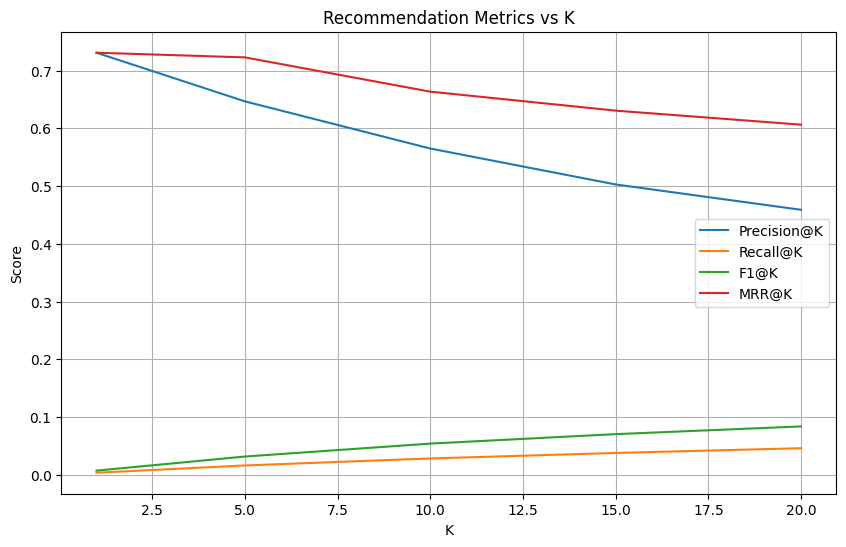

In [ ]:
import matplotlib.pyplot as plt

def evaluate_across_k(k_values=[1, 5, 10, 15, 20]):
    precisions, recalls, f1s, mrrs = [], [], [], []

    for k in k_values:
        precision_total = 0
        recall_total = 0
        f1_total = 0
        mrr_total = 0
        valid_count = 0

        for i in range(len(df)):
            true_label = df.loc[i, 'Label']
            recs = recommend_papers_by_index(i, top_n=k)
            tp = (recs['Label'] == true_label).sum()
            precision = tp / k
            total_relevant = (df['Label'] == true_label).sum() - 1
            if total_relevant <= 0:
                continue
            recall = tp / total_relevant
            f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
            mrr = 0
            for rank, label in enumerate(recs['Label'], start=1):
                if label == true_label:
                    mrr = 1 / rank
                    break
            precision_total += precision
            recall_total += recall
            f1_total += f1
            mrr_total += mrr
            valid_count += 1

        precisions.append(precision_total / valid_count)
        recalls.append(recall_total / valid_count)
        f1s.append(f1_total / valid_count)
        mrrs.append(mrr_total / valid_count)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, precisions, label='Precision@K')
    plt.plot(k_values, recalls, label='Recall@K')
    plt.plot(k_values, f1s, label='F1@K')
    plt.plot(k_values, mrrs, label='MRR@K')
    plt.xlabel("K")
    plt.ylabel("Score")
    plt.title("Recommendation Metrics vs K")
    plt.legend()
    plt.grid(True)
    plt.show()

evaluate_across_k()

**Error** **Analysis**

Confusion Matrix (True rows x Predicted columns):
                                           gene expression analysis  \
gene expression analysis                                        183   
sequence classification and alignment                            16   
protein structure and function prediction                         5   
biological image analysis                                        28   
disease outcome prediction                                       37   

                                           sequence classification and alignment  \
gene expression analysis                                                       8   
sequence classification and alignment                                        116   
protein structure and function prediction                                     30   
biological image analysis                                                     12   
disease outcome prediction                                                    11   

                  

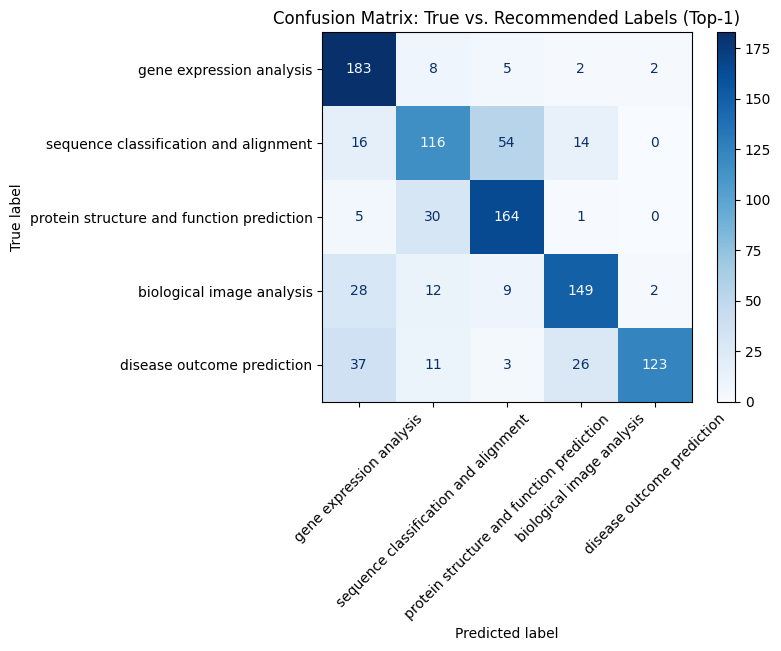

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

y_true = []
y_pred = []

for i in range(len(df)):
    true_label = df.loc[i, 'Label']
    recs = recommend_papers_by_index(i, top_n=1)
    if not recs.empty:
        pred_label = recs.iloc[0]['Label']
        y_true.append(true_label)
        y_pred.append(pred_label)

labels = df['Label'].unique()

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Display confusion matrix as a DataFrame
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
print("Confusion Matrix (True rows x Predicted columns):")
print(cm_df)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('Confusion Matrix: True vs. Recommended Labels (Top-1)')
plt.show()



The recommender tends to do better for papers with higher citations on average.

Zero citation papers (new or less popular) are predicted correctly and incorrectly quite often.

=== Citation Count Stats ===
Correct predictions count: 735
Incorrect predictions count: 265

Stats for Correct predictions:
  Mean citations: 27.13
  Median citations: 3.00
  Citation std dev: 164.73
  Min citations: 0.0
  Max citations: 4092.0

Stats for Incorrect predictions:
  Mean citations: 20.56
  Median citations: 3.00
  Citation std dev: 50.00
  Min citations: 0.0
  Max citations: 466.0

Zero citation count (correct): 223
Zero citation count (incorrect): 104


/tmp/ipython-input-33-2359922883.py:51: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(correct_citations, label='Correct Predictions', shade=True)
/tmp/ipython-input-33-2359922883.py:52: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(incorrect_citations, label='Incorrect Predictions', shade=True)


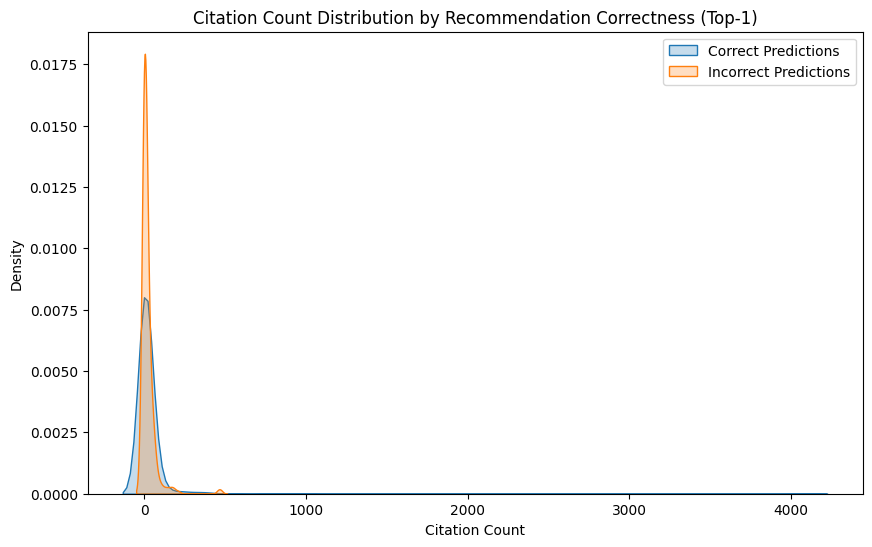

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

citation_col = 'Times Cited, All Databases'

correct_citations = []
incorrect_citations = []

for i in range(len(df)):
    true_label = df.loc[i, 'Label']
    recs = recommend_papers_by_index(i, top_n=1)
    if not recs.empty:
        pred_label = recs.iloc[0]['Label']
        citations = df.loc[i, citation_col]
        if pd.isna(citations):
            citations = 0

        if pred_label == true_label:
            correct_citations.append(citations)
        else:
            incorrect_citations.append(citations)

# Convert lists to numpy arrays for statistics
correct_citations = np.array(correct_citations)
incorrect_citations = np.array(incorrect_citations)

# Print basic statistics
print("=== Citation Count Stats ===")
print(f"Correct predictions count: {len(correct_citations)}")
print(f"Incorrect predictions count: {len(incorrect_citations)}")

def print_stats(arr, label):
    print(f"\nStats for {label}:")
    print(f"  Mean citations: {np.mean(arr):.2f}")
    print(f"  Median citations: {np.median(arr):.2f}")
    print(f"  Citation std dev: {np.std(arr):.2f}")
    print(f"  Min citations: {np.min(arr)}")
    print(f"  Max citations: {np.max(arr)}")

print_stats(correct_citations, "Correct predictions")
print_stats(incorrect_citations, "Incorrect predictions")

# Also show counts of zero citations (potentially new or unpopular papers)
print(f"\nZero citation count (correct): {(correct_citations == 0).sum()}")
print(f"Zero citation count (incorrect): {(incorrect_citations == 0).sum()}")

# Visualization
plt.figure(figsize=(10,6))
sns.kdeplot(correct_citations, label='Correct Predictions', shade=True)
sns.kdeplot(incorrect_citations, label='Incorrect Predictions', shade=True)
plt.title('Citation Count Distribution by Recommendation Correctness (Top-1)')
plt.xlabel('Citation Count')
plt.ylabel('Density')
plt.legend()
plt.show()


**examples of failed recommendations **
*The misclassification is caused by metadata similarity dominating the final score, despite low content match.*

1. Content similarity is weak for everyone.
The highest content sim is 0.334 (from an unrelated image analysis paper).

The content similarity for correct-label neighbors is even lower than for some wrong-label ones.

2. Metadata similarity is the dominant driver.
Neighbors like 223 and 388 (wrong label) have very high metadata similarity (~0.
99), which pushed their final similarity up.

Even though their content is very weak (0.03–0.07), the final similarity still becomes highest because metadata dominates.

3. Final prediction is swayed by metadata bias.
Your model is over-relying on metadata similarity (possibly same authors, publication year, journal, etc.).

Even unrelated content gets pulled up due to shared metadata traits.

In [40]:
def get_top_neighbors(paper_idx, top_n=10):
    # Get similarity scores for the paper
    cs_scores = content_similarity[paper_idx]
    ms_scores = metadata_similarity[paper_idx]
    fs_scores = final_similarity[paper_idx]

    # Get indices of top N neighbors (excluding self)
    top_fs = np.argsort(fs_scores)[::-1]
    top_fs = top_fs[top_fs != paper_idx][:top_n]

    # Create a DataFrame with similarity info
    neighbor_info = df.iloc[top_fs][['Article Title', 'Label']].copy()
    neighbor_info['Index'] = top_fs
    neighbor_info['Content_Similarity'] = cs_scores[top_fs]
    neighbor_info['Metadata_Similarity'] = ms_scores[top_fs]
    neighbor_info['Final_Similarity'] = fs_scores[top_fs]

    return neighbor_info
# Find one misclassified example
misclassified = df[df['Label'] != df['Predicted_Label_Recommender']]
example_idx = misclassified.index[0]  # pick the first one

print("Paper:", df.loc[example_idx, 'Article Title'])
print("True Label:", df.loc[example_idx, 'Label'])
print("Predicted by Recommender:", df.loc[example_idx, 'Predicted_Label_Recommender'])

# Analyze top neighbors
neighbors = get_top_neighbors(example_idx, top_n=10)
print(neighbors[['Label', 'Content_Similarity', 'Metadata_Similarity', 'Final_Similarity']])


Paper: Dissimilarity based ensemble of extreme learning machine for gene expression data classification
True Label: gene expression analysis
Predicted by Recommender: sequence classification and alignment
                                         Label  Content_Similarity  \
223      sequence classification and alignment            0.075423   
701                  biological image analysis            0.334495   
131                   gene expression analysis            0.063604   
121                   gene expression analysis            0.047650   
388      sequence classification and alignment            0.031523   
538  protein structure and function prediction            0.013442   
488  protein structure and function prediction            0.249246   
201      sequence classification and alignment            0.246039   
294      sequence classification and alignment            0.137955   
585  protein structure and function prediction            0.014297   

     Metadata_Similarity